# Phase Esitimation Eigensolver

In [1]:
import qiskit.quantum_info as qi
import numpy as np
import pandas as pd

In [2]:
def I0(L):
    label = ""
    for i in range(0,L):
        label += "I"
    return qi.Operator.from_label(label).data

def X(l,L):
    label = ""
    for i in range(0,l):
        label += "I"
    label += "X"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def Y(l,L):
    label = ""
    for i in range(0,l):
        label += "I"
    label += "Y"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def Z(l,L):
    label = ""
    for i in range(0,l):
        label += "I"
    label += "Z"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def Mdot(Ol):
    m = Ol[0]
    for i in range(1,len(Ol)):
        m = np.dot(Ol[i],m)
    return m

## Quantum fourier transform

In [3]:
def H(l,L):
    return 1/np.sqrt(2)*(X(l,L)+Z(l,L))

def SWAP(l,ll,L):
    return 1/2*(Mdot([X(l,L),X(ll,L)])+Mdot([Y(l,L),Y(ll,L)])+I0(L)+Mdot([Z(l,L),Z(ll,L)]))

def CROT(k,l,ll,L):
    return I0(L)-1/4*Mdot([(I0(L)-Z(l,L)),(I0(L)-Z(ll,L))])+np.exp(1j*2*np.pi/(2**k))*1/4*Mdot([(I0(L)-Z(l,L)),(I0(L)-Z(ll,L))])

In [244]:
def apply_QFT(psi):
    check = []
    L = int(np.log2(len(psi)))
    psi_f = psi
    check.append("psi")
    for l in range(0,L):
        psi_f = Mdot([H(l,L),psi_f])
        check.append("H"+str(l))
        for ll in range(l+1,L):
            k = (ll-l)+1
            psi_f = Mdot([CROT(k,l,ll,L),psi_f])
            check.append("C"+str(k)+str(l)+str(ll))
    for l in range(0,int(L/2)):
        psi_f = Mdot([SWAP(l,L-1-l,L),psi_f])
        check.append("S"+str(l)+str(L-1-l))
    print(check)
    return psi_f

def QFT(L):
    out = I0(L)
    for l in range(0,L):
        out = Mdot([H(l,L),out])
        for ll in range(l+1,L):
            k = (ll-l)+1
            out = Mdot([CROT(k,l,ll,L),out])
    for l in range(0,int(L/2)):
        out = Mdot([SWAP(l,L-1-l,L),out])
    return out

def QFT_R(L):
    return np.conjugate(np.transpose(QFT(L)))

In [226]:
psi = qi.Statevector.from_label("101").data

Mdot([QFT(3),psi])

array([ 3.53553391e-01+0.j        , -2.50000000e-01-0.25j      ,
        2.16489014e-17+0.35355339j,  2.50000000e-01-0.25j      ,
       -3.53553391e-01+0.j        ,  2.50000000e-01+0.25j      ,
       -2.16489014e-17-0.35355339j, -2.50000000e-01+0.25j      ])

## Quantum Phase Estimation

Here we will do quantum phase exitmation on a unitary whose eigenstate we already know.  In the next section we will find the eigenstate.

First I define the trial unitary

In [366]:
import scipy.linalg as lng


U1 = np.cos(0.31)*I0(2)-1j*np.sin(0.31)*Mdot([Z(0,2)])
U2 = np.cos(1.37)*I0(2)-1j*np.sin(1.37)*Mdot([Z(1,2)])
Uxx = np.cos(0.31)*I0(2)-1j*np.sin(0.31)*Mdot([X(0,2),X(1,2)])
U = Mdot([U1,U2,Uxx])

np.amax(np.abs(Mdot([np.conjugate(np.transpose(U)),U])-I0(2)))

2.2206508537722626e-16

and find the eiganvectors which will be needed for the initialization

In [367]:
(e,y) = lng.eig(U)
psi = np.conjugate(np.transpose(y))
np.amax(np.abs(Mdot([U,psi[0]])-e[0]*psi[0]))

2.2247786310271853e-16

Now we have everything we need for input.  Let's go ahead and define the phase estimation function.

In [368]:
def QPE(U,psi,p):
    #initialize
    L = int(np.log2(len(psi)))
    ancilla = np.array([0 for i in range(0,2**p)])
    ancilla[0] = 1;
    psi0 = np.kron(ancilla,psi)

    #apply Hardamard gates
    psi1 = psi0
    for i in range(0,p):
        psi1 = Mdot([H(i,p+L),psi1]) 

    #apply controlled unitaries
    IU = np.kron(I0(p),U)
    def CU(a):
        return 1/2*(I0(p+L)+Z(a,p+L)+IU-Mdot([IU,Z(a,p+L)]))

    psi2 = psi1
    for i in range(0,p):
        for n in range(0,2**(p-i-1)):
            psi2 = Mdot([CU(i),psi2])

    #apply inverse QFT
    QI = np.kron(QFT_R(p),I0(L))
    psi3 = Mdot([QI,psi2])

    #Measure the ancilla basis
    Pl = []
    xl = []
    for x in range(0,2**p):
        px = 0
        for i in range(0,2**L):
            px += np.abs(psi3[2**L*x+i])**2
        Pl.append(px)
        xl.append(x)

    #Find the maximum and return the phase
    xm = Pl.index(np.amax(Pl))
    theta = xm/(2**p)
    phase = np.exp(2*np.pi*1j*theta)
    
    return Pl, xl, theta, phase

We can check that the phase is close to the eigenvalue (increasing p increases the persicion)

In [376]:
Pl, xl, theta, phase = QPE(U,psi[2],6)
print(phase)
e

(0.4713967368259978+0.8819212643483549j)


array([-0.10379174-0.99459905j, -0.10379174+0.99459905j,
        0.46556929+0.88501143j,  0.46556929-0.88501143j])

We can also look at the probability distribution

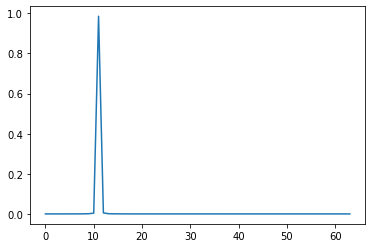

In [377]:
import matplotlib.pyplot as plt

plt.plot(xl,Pl)

I did not end up using the function below but it is helpful for understanding how the states represent binary numbers.  bx(x,p,L) takes a numberical number x and converts it into binary given that the first L qubits are not involved and the length of the binary string should be p.  Then we can build the state from the binary number using the quantum information package.

In [378]:
def bx(x,p,L):
    out = bin((2**L)*x)[2:]
    Lb = len(out)
    for i in range(Lb,p+L):
        out = '0'+out
    return out

x = 7
print(bx(x,p,L))
qi.Statevector.from_label(bx(x,p,L)).data

011100


array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

## Eigensolver

In [393]:
psi_mix = 1/2*(psi[0]-psi[1]+psi[2]+1j*psi[3])
Pl, xl, theta, phase = QPE(U,psi_mix,6)

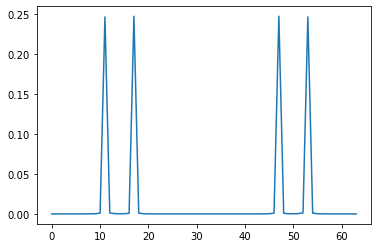

In [394]:
import matplotlib.pyplot as plt

plt.plot(xl,Pl)

Notice that all peaks are generally present when the initial sate is a mix of eigenvalues.  To prepare the ground state, we find the peak which corresponds to the lowest eigenvalue and then keep the first state we find whose ancilla measurment is in this peak.